<a href="https://colab.research.google.com/github/Vcarmelli/Peptide-Generation/blob/main/PROJECT_Peptide_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install hf_xet --quiet
!pip install transformers peft accelerate bitsandbytes --quiet
!pip install nltk --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00


In [ ]:
#@title Load Model and LORA Adapters

from transformers import T5Tokenizer, T5ForConditionalGeneration, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType # Parameter-efficient fine-tuning (peft)

bnb_config = BitsAndBytesConfig(load_in_8bit=True)  # memory saver load model in lower bit
model = T5ForConditionalGeneration.from_pretrained(
    "Rostlab/prot_t5_xl_uniref50",
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
    target_modules=["q", "v"]  # typical for T5 attention
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


trainable params: 5,898,240 || all params: 2,824,728,576 || trainable%: 0.2088


In [ ]:
#@title Pre-process data
import pandas as pd

csv_folder = "/content/drive/MyDrive/csv/Final Datasets"
df = pd.read_csv(f'{csv_folder}/peptides_with_labels.csv')

def preprocess(row):
    sequence_id = row["ID"]
    target = row["Target"]
    sequence = ' '.join(list(row["Sequence"]))  # space between amino acids
    inhibition = row["IC50"] if pd.notna(row["IC50"]) else 0
    return pd.Series([sequence_id, target, sequence, inhibition])

df[['sequence_id','target', 'peptide', 'inhibition']] = df.apply(preprocess, axis=1)
df = df[['sequence_id', 'target', 'peptide', 'inhibition']]
df.head()

,sequence_id,target,peptide,inhibition
0,DRAVPe01639,1,G Q G K A H N G R L I T A N P,33.0
1,DRAVPe01639,2,G Q G K A H N G R L I T A N P,10.0
2,DRAVPe01639,3,G Q G K A H N G R L I T A N P,20.0
3,DRAVPe01639,4,G Q G K A H N G R L I T A N P,20.0
4,DRAVPe01638,1,D R G W G N G C G L F G,10.0


In [ ]:
#@title Build Dataset
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch

class PeptideDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=300):
        self.tokenizer = tokenizer
        self.inputs = dataframe['target'].tolist()
        self.peptides = dataframe['peptide'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = f"serotype: {self.inputs[idx]}"
        target_text = f"peptide: {self.peptides[idx]}"

        input_enc = tokenizer(input_text, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        target_enc = tokenizer(target_text, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = target_enc["input_ids"].squeeze()
        labels[labels == tokenizer.pad_token_id] = -100  # mask padding
        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": labels
        }

# Split training and validation datasets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = PeptideDataset(train_df, tokenizer)
val_dataset = PeptideDataset(val_df, tokenizer)

print("Train data:", len(train_dataset))
print("Validation data:", len(val_dataset))

Train data: 132
Validation data: 33


In [ ]:
#@title Train ProtT5 Model with Early Stopping
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

early_stop = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop after 2 evals with no improvement
    early_stopping_threshold=0.001  # Optional: min improvement required
)

training_args = TrainingArguments(
    output_dir="./protT5-lora-peptide",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,  # simulate like batch_size=2
    num_train_epochs=10,
    learning_rate=5e-4,
    logging_strategy="epoch",
    save_total_limit=1,
    fp16=False,
    bf16=False,
    optim="adamw_torch", # lighter optimizer
    lr_scheduler_type="linear",
    save_strategy="epoch",
    eval_strategy="epoch",
    eval_steps=10,
    logging_dir="./logs",
    load_best_model_at_end=True,
    greater_is_better=False,  # Lower loss is better
    report_to="none",   # no wandb/logging crashes
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stop]
)

trainer.train()

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,4.513500,3.074219
2,2.943600,2.875000
3,2.799500,2.750000
4,2.641800,2.669922
5,2.456900,2.484375
6,2.283700,2.271484
7,2.120700,2.230469
8,1.969800,2.175781
9,1.892500,2.148438
10,1.812900,2.119141


TrainOutput(global_step=660, training_loss=2.543484404592803, metrics={'train_runtime': 1181.2233, 'train_samples_per_second': 1.117, 'train_steps_per_second': 0.559, 'total_flos': 6711238803456000.0, 'train_loss': 2.543484404592803, 'epoch': 10.0})

In [ ]:
#@title Save Finetuned Model to Drive
model.save_pretrained("/content/drive/My Drive/model")

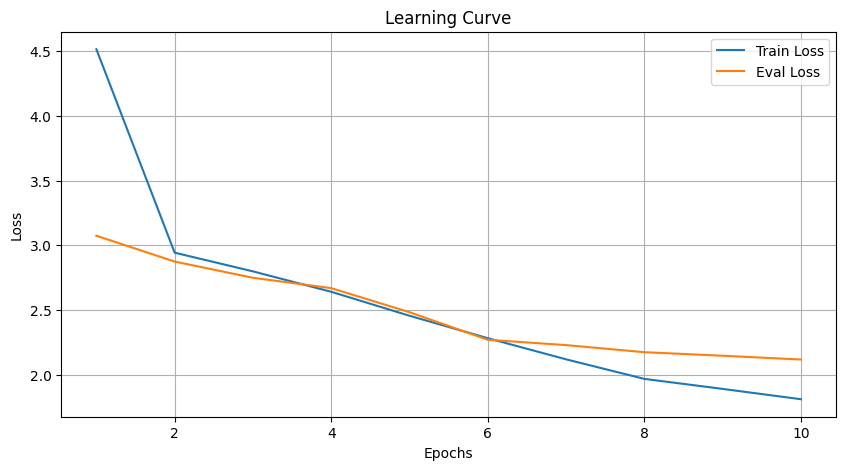

In [ ]:
#@title Plot Model's Learning Curve

import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(trainer):
    logs = trainer.state.log_history
    train_loss = [entry["loss"] for entry in logs if "loss" in entry]
    eval_loss = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
    steps = [entry["epoch"] for entry in logs if "loss" in entry]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_loss, label="Train Loss")
    if eval_loss:
        eval_steps = [entry["epoch"] for entry in logs if "eval_loss" in entry]
        plt.plot(eval_steps, eval_loss, label="Eval Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(trainer)

In [ ]:
#@title Load helper functions for peptide generation

STANDARD_AMINO_ACIDS = set("ACDEFGHIKLMNPQRSTVWY")
# checks peptide length, duplicates, and standard amino acids
def is_valid_peptide(peptide, existing_peptides):
    min_length = 10

    if len(peptide) < min_length:
        return False
    if existing_peptides and peptide in existing_peptides:
        return False

    # Check for non-standard amino acids
    if not all(aa in STANDARD_AMINO_ACIDS for aa in peptide):
        return False

    if peptide.count("RR") > 1:
        return False

    return True

def generate_peptide(serotype, seq_length):
    input_ids = tokenizer(serotype, return_tensors="pt").input_ids.to(model.device)
    output_ids = model.generate(
        input_ids=input_ids,
        do_sample=True,
        top_k=50,
        top_p=0.7,
        temperature=1.5,
        max_length=seq_length,
        num_return_sequences=1, # one at a time to check validity
        repetition_penalty=1.8,
    )
    # Decode and remove spaces
    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    peptide = decoded.replace(" ", "")
    return peptide

In [ ]:
#@title Start Peptide Generation
def peptide_generator(serotype, seq_length, num_of_sequences):
    seq_counter = 0
    min_length = 5
    peptides = []
    unique_peptides = set()
    not_complete = True

    prompt = f"serotype: {serotype}"
    print(f"Serotype {serotype}:")
    while not_complete:
        if num_of_sequences == len(peptides):
          not_complete = False   # completed
          break

        peptide = generate_peptide(prompt, seq_length)
        if not is_valid_peptide(peptide, unique_peptides):
            continue

        seq_counter += 1
        peptides.append({
            "serotype": serotype,
            "sequence_id": f"DENV{serotype}SEQ{seq_counter:02d}",
            "peptide": peptide
        })
        print(f"  {seq_counter}. Peptide: {peptide}")
        unique_peptides.add(peptide)

    return pd.DataFrame(peptides)


# Generate for each serotypes
all_peptides = []
for serotype in ["1", "2", "3", "4"]:
    new = peptide_generator(serotype, seq_length=200, num_of_sequences=10)
    all_peptides.append(new)

peptides_df = pd.concat(all_peptides, ignore_index=True)

peptides_df.to_csv(f"{csv_folder}/generated_peptides.csv", index=False)
print(f"Peptides saved as generated_peptides.csv in {csv_folder}")

Serotype 1:
  1. Peptide: RRRKTCG
  2. Peptide: ADLPEGW
  3. Peptide: EGRLKF
  4. Peptide: RRHFCW
  5. Peptide: RGKRPAC
  6. Peptide: AEGHW
  7. Peptide: PGKRKSC
  8. Peptide: RRRRYWCGY
  9. Peptide: RGWFAKCTV
  10. Peptide: AGYHPEFDL
Serotype 2:
  1. Peptide: RRHWCW
  2. Peptide: AKRRH
  3. Peptide: RGWFKN
  4. Peptide: RGRGHAV
  5. Peptide: LKARH
  6. Peptide: LKRRH
  7. Peptide: GRRRWCY
  8. Peptide: RRRRWWCGY
  9. Peptide: RRRRGCSY
  10. Peptide: RRRKTLCF
Serotype 3:
  1. Peptide: ELWRFG
  2. Peptide: LEDCW
  3. Peptide: ALDKR
  4. Peptide: LEFGRRKSVAN
  5. Peptide: RRHWCWY
  6. Peptide: RGWLHKAY
  7. Peptide: LKRRH
  8. Peptide: PWWCG
  9. Peptide: LKRKH
  10. Peptide: LKKRH
Serotype 4:
  1. Peptide: AKRKSL
  2. Peptide: RRRRWCY
  3. Peptide: PKRGH
  4. Peptide: PKRKSL
  5. Peptide: AWSFGAVTPVI
  6. Peptide: RRHLCGY
  7. Peptide: LKHRH
  8. Peptide: EKRRH
  9. Peptide: LELKH
  10. Peptide: RRRRHWCCY
Peptides saved as generated_peptides.csv in /content/drive/MyDrive/csv/Final Datas

## Limitations:
*   Model can't generate longer sequence even max_length is set

---

### Notes:
*As of May 3*

* After generating peptides it is saved as csv file to process for inhibition prediction